In [2]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.mixture import GaussianMixture as GMM
from sklearn.decomposition import PCA, FastICA
from sklearn import linear_model
from matplotlib import pyplot as plt, cm as cm, mlab as mlab
%matplotlib inline
import seaborn as sns; sns.set()
import time 
import math
import os

In [5]:
# read csv/excel data files 
# dataPath1 = os.path.abspath(os.path.join("..","data","pnas_data1.csv")) #20 imputed sets
# dataPath2 = os.path.abspath(os.path.join("..","data","pnas_data2.csv")) #20 imputed sets
pnas_data1 = pd.read_csv('pnas_data1.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [7]:
# format data 

def svd(data):
    """
    perform singular value decomposition on the given data matrix
    """
    #center the data
    mean = np.mean(data, axis=0)
    data -= mean
    
    P, D, Q = np.linalg.svd(data, full_matrices=False)
    
    return P, D, Q

# extract 9 Complexity Characteristic variables 
features = ['PolPop', 'PolTerr', 'CapPop', 'levels', 'government','infrastr', 'writing', 'texts', 'money']
feature_time = ['Time'] + features
# take subset of original data table with 9 CCs and change it into numpy array 
data_mat = StandardScaler().fit_transform(pnas_data1.loc[:, features].values)
times = pnas_data1.loc[:, ['Time']].values
ngas = pnas_data1.NGA.unique().tolist()
P, D, Q = svd(data_mat)
Q = normalize(Q, axis=0)
data = np.matmul(data_mat, Q.T)


## Interpolated version

In [9]:
import scipy.spatial as spatial

def meanVector(u0,v0,r0,flowArrayInterp,minPoints=10):
    # Remove endpoints
    ind = [True if not np.isnan(flowArrayInterp[i,0,1]) else False for i in range(flowArrayInterp.shape[0])]
    u = flowArrayInterp[ind,0,0]
    v = flowArrayInterp[ind,1,0]
    du = flowArrayInterp[ind,0,1]
    dv = flowArrayInterp[ind,1,1]
    points = np.column_stack((u,v))
    point_tree = spatial.cKDTree(points)
    neighb = point_tree.query_ball_point([u0,v0],r0)
    if len(neighb) >= minPoints :
        du0 = np.mean(du[neighb])
        dv0 = np.mean(dv[neighb])
        mm0 = np.sqrt(np.sum(np.power(du[neighb] - du0,2) + np.power(dv[neighb]-dv0,2))/len(neighb))
        return [du0,dv0,mm0]
    else:
        return None

# Generate the un-interpolated flow dataset
flowArray = np.empty(shape=(0,9,2)) # Initialize the flow array 
flowInfo = pd.DataFrame(columns=['NGA','Time']) # Initialize the info dataframe

# Iterate over NGAs to populate flowArray and flowInfo
for nga in ngas:
    indNga = pnas_data1["NGA"] == nga # boolean vector for slicing by NGA
    times = sorted(np.unique(pnas_data1.loc[indNga,'Time'])) # Vector of unique times
    for i_t,t in enumerate(times):
        ind = indNga & (pnas_data1['Time']==t) # boolean vector for slicing also by time
        newInfoRow = pd.DataFrame(data={'NGA': [nga], 'Time': [t]})
        flowInfo = flowInfo.append(newInfoRow,ignore_index=True)
        newArrayEntry = np.empty(shape=(1,9,2))
        for p in range(flowArray.shape[1]):
            newArrayEntry[0,p,0] = np.mean(data[ind,p])
            if i_t < len(times) - 1:
                nextTime = times[i_t + 1]
                nextInd = indNga & (pnas_data1['Time']==nextTime) # boolean vector for slicing also by time
                nextVal = np.mean(data[nextInd,p])
                newArrayEntry[0,p,1] = nextVal - newArrayEntry[0,p,0]
            else:
                newArrayEntry[0,p,1] = np.nan
        flowArray = np.append(flowArray,newArrayEntry,axis=0)

# Iterate over NGAs to populate flowArrayInterp and flowInfoInterp
flowArrayInterp = np.empty(shape=(0,9,2)) # Initialize the flow array 
flowInfoInterp = pd.DataFrame(columns=['NGA','Time']) # Initialize the info dataframe
interpTimes = np.arange(-9600,1901,100)
for nga in ngas:
    indNga = pnas_data1["NGA"] == nga # boolean vector for slicing by NGA
    times = sorted(np.unique(pnas_data1.loc[indNga,'Time'])) # Vector of unique times

    for i_t,t in enumerate(interpTimes):
        if t >= min(times) and t <= max(times): # Is the time in the NGAs range?
            newInfoRow = pd.DataFrame(data={'NGA': [nga], 'Time': [t]})
            flowInfoInterp = flowInfoInterp.append(newInfoRow,ignore_index=True)
            newArrayEntry = np.empty(shape=(1,9,2))
            for p in range(flowArrayInterp.shape[1]):
                # Interpolate using flowArray
                indFlow = flowInfo['NGA'] == nga
                tForInterp = np.array(flowInfo['Time'][indFlow],dtype='float64')
                pcForInterp = flowArray[indFlow,p,0]
                currVal = np.interp(t,tForInterp,pcForInterp)
                newArrayEntry[0,p,0] = currVal
                if i_t < len(interpTimes) - 1:
                    nextTime = interpTimes[i_t + 1]
                    nextVal = np.interp(nextTime,tForInterp,pcForInterp)
                    newArrayEntry[0,p,1] = nextVal - currVal
                else:
                    newArrayEntry[0,p,1] = np.nan
            flowArrayInterp = np.append(flowArrayInterp,newArrayEntry,axis=0)
            
u0Vect = np.arange(-7,7.1,.2)
v0Vect = np.arange(-7,7.1,.2)
du0Mat = np.empty(shape=(len(u0Vect),len(v0Vect)))
dv0Mat = np.empty(shape=(len(u0Vect),len(v0Vect)))
mm0Mat = np.empty(shape=(len(u0Vect),len(v0Vect)))
r0 = .75
for ii,u0 in enumerate(u0Vect):
    for jj,v0 in enumerate(v0Vect):
        meanCalc = meanVector(u0,v0,r0,flowArrayInterp) # [du0, dv0, mm0]
        if meanCalc is not None:
            du0Mat[ii,jj] = meanCalc[0]
            dv0Mat[ii,jj] = meanCalc[1]
            mm0Mat[ii,jj] = meanCalc[2]
        else:
            du0Mat[ii,jj] = np.nan
            dv0Mat[ii,jj] = np.nan
            mm0Mat[ii,jj] = np.nan

def calcMeanVectorsSlice(u0Vect,v0Vect,r0,flowArrayInterp,minPoints=10):
    # Remove endpoints
    ind = [True if not np.isnan(flowArrayInterp[i,0,1]) else False for i in range(flowArrayInterp.shape[0])]
    fa = flowArrayInterp[ind,:,:]

    points9D = flowArrayInterp[:,:,0]
    points9D = points9D[ind,:]
    tree9D = spatial.cKDTree(points9D)

    # Calculate the mean for the remaining seven PCs
    otherMeans = np.empty(7)
    for ii in range(0,flowArrayInterp.shape[1]-2):
        otherMeans[ii] = np.mean(flowArrayInterp[:,ii+2,0])

    # Initialize the matrices
    du0Mat = np.empty((len(u0Vect),len(v0Vect)))
    dv0Mat = np.empty((len(u0Vect),len(v0Vect)))
    mm0Mat = np.empty((len(u0Vect),len(v0Vect)))

    for i,u0 in enumerate(u0Vect):
        for j,v0 in enumerate(v0Vect):
            z0 = np.hstack((u0,v0,otherMeans))
            neighb = tree9D.query_ball_point(z0,r0)
            if len(neighb) >= minPoints:
                du0Mat[i,j] = np.mean(fa[neighb,0,1])
                dv0Mat[i,j] = np.mean(fa[neighb,1,1])
                #Pdb().set_trace()
                mm0Mat[i,j] = np.sqrt(np.sum(np.power(fa[neighb,0,1] - du0Mat[i,j],2) + np.power(fa[neighb,1,1]-dv0Mat[i,j],2))/len(neighb))
            else:
                du0Mat[i,j] = np.nan
                dv0Mat[i,j] = np.nan
                mm0Mat[i,j] = np.nan
    return du0Mat,dv0Mat,mm0Mat


    # Using the weighting procedure describe in Supplementary Information
    # dGrid is grid spacing (same for both dimensions, PC1 and PC2)
    # r0 is radius for choosing points

    # Remove endpoints
    ind = [True if not np.isnan(flowArrayInterp[i,0,1]) else False for i in range(flowArrayInterp.shape[0])]
    fa = flowArrayInterp[ind,:,:]
    points2D = fa[:,range(0,2),0]
    tree2D = spatial.cKDTree(points2D)

    du0Mat = np.empty((len(u0Vect),len(v0Vect)))
    dv0Mat = np.empty((len(u0Vect),len(v0Vect)))
    mm0Mat = np.empty((len(u0Vect),len(v0Vect)))

    for i,u0 in enumerate(u0Vect):
        for j,v0 in enumerate(v0Vect):
            neighb = tree2D.query_ball_point([u0,v0],r0)
            if len(neighb) >= minPoints:
                weights = np.empty(len(neighb))
                for k,n in enumerate(neighb):
                    dx = np.sqrt(np.power(points2D[n,0] - u0,2) + np.power(points2D[n,1] - v0,2))
                    d = np.sqrt(np.power(r0,2) - np.power(dx,2))
                    weights[k] = np.power(d,7)
                weights = weights / np.sum(weights)
                #weights = np.ones(len(neighb)) # Uncomment to compare with old approach
                #weights = weights / len(weights)
                du0Mat[i,j] = np.sum(fa[neighb,0,1] * weights)
                #Pdb().set_trace()
                dv0Mat[i,j] = np.sum(fa[neighb,1,1] * weights)
                mm0Mat[i,j] = np.sqrt(np.sum(weights*np.power(fa[neighb,0,1] - du0Mat[i,j],2) + weights*np.power(fa[neighb,1,1]-dv0Mat[i,j],2)))
            else:
                du0Mat[i,j] = np.nan
                dv0Mat[i,j] = np.nan
                mm0Mat[i,j] = np.nan
    return du0Mat,dv0Mat,mm0Mat
PC_matrix = data
CC_df = pnas_data1
NGAs = ngas

# Iterate over NGAs to populate flowArrayInterp and flowInfoInterp
flowArrayInterp = np.empty(shape=(0,9,2)) # Initialize the flow array 
flowInfoInterp = pd.DataFrame(columns=['NGA','Time']) # Initialize the info dataframe
interpTimes = np.arange(-9600,1901,100)
for nga in NGAs:
    indNga = CC_df["NGA"] == nga # boolean vector for slicing by NGA
    times = sorted(np.unique(CC_df.loc[indNga,'Time'])) # Vector of unique times

    for i_t,t in enumerate(interpTimes):
        if t >= min(times) and t <= max(times): # Is the time in the NGAs range?
            newInfoRow = pd.DataFrame(data={'NGA': [nga], 'Time': [t]})
            flowInfoInterp = flowInfoInterp.append(newInfoRow,ignore_index=True)
            newArrayEntry = np.empty(shape=(1,9,2))
            for p in range(flowArrayInterp.shape[1]):
                # Interpolate using flowArray
                indFlow = flowInfo['NGA'] == nga
                tForInterp = np.array(flowInfo['Time'][indFlow],dtype='float64')
                pcForInterp = flowArray[indFlow,p,0]
                currVal = np.interp(t,tForInterp,pcForInterp)
                newArrayEntry[0,p,0] = currVal
                if i_t < len(interpTimes) - 1:
                    nextTime = interpTimes[i_t + 1]
                    nextVal = np.interp(nextTime,tForInterp,pcForInterp)
                    newArrayEntry[0,p,1] = nextVal - currVal
                else:
                    newArrayEntry[0,p,1] = np.nan
            flowArrayInterp = np.append(flowArrayInterp,newArrayEntry,axis=0)

# Modify flow array interp to be for movements in rather than movements out
flowArrayInInterp = np.copy(flowArrayInterp)
flowArrayInInterp[:,:,1] = np.nan

ind = np.where([True if np.isnan(flowArrayInterp[i,0,1]) else False for i in range(flowArrayInterp.shape[0])])[0]
loVect = np.insert(ind[0:(-1)],0,0)
hiVect = ind - 1
for lo,hi in zip(loVect,hiVect):
    for k in range(lo,hi+1):
        flowArrayInInterp[k+1,:,1] = flowArrayInterp[k,:,1]

/home/jae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/jae/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


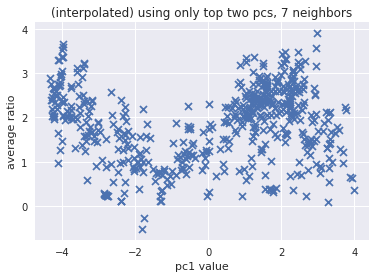

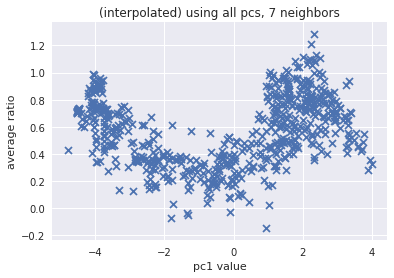

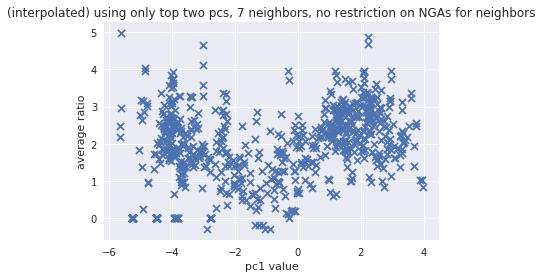

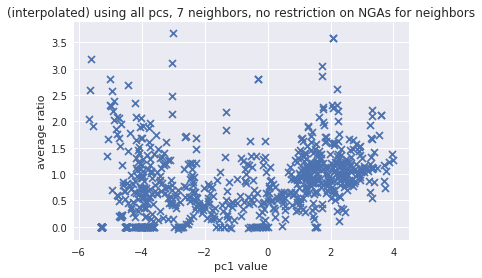

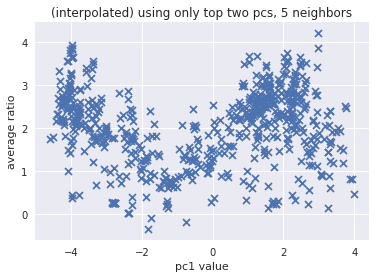

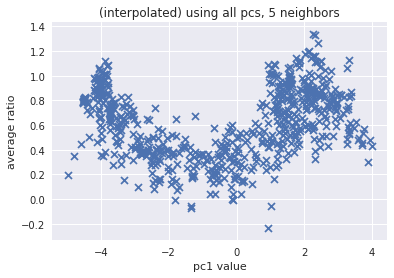

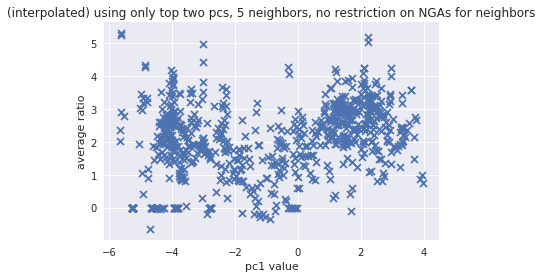

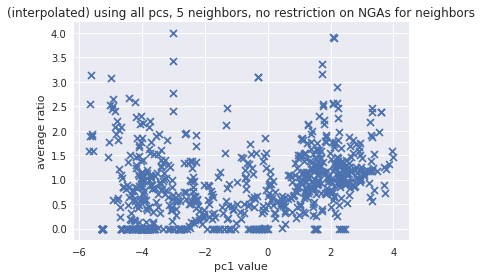

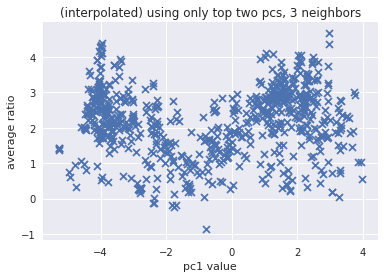

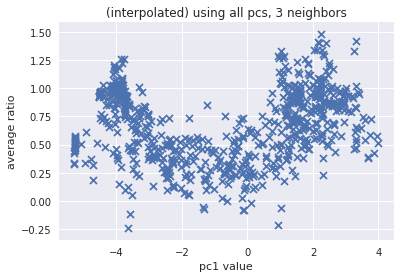

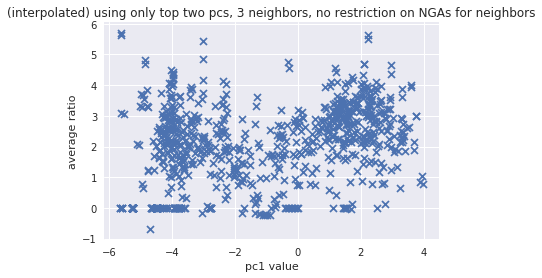

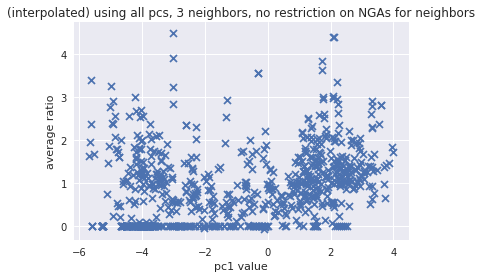

In [24]:
num_observ = flowArrayInInterp.shape[0]
invalid_input = [i for i in range(num_observ) if np.isnan(flowArrayInInterp[i, :, :]).any()]
flow_ngas_interp = np.delete(flowInfoInterp['NGA'].values, invalid_input)
flowArrayInInterp2 = flowArrayInInterp[list(set(range(num_observ)).difference(set(invalid_input))), :, :]
num_observ = flowArrayInInterp2.shape[0]
assert len(flow_ngas_interp) == num_observ

def dist(vec1, vec2):
    """
    Euclidean distance between two vectors
    """
    return np.linalg.norm(vec1-vec2)

def flow_distance(flowvec_nga, polity_arrays, num_nbrs, nbrnear=True, pc12 = True, title=None):
    pc1_val = []
    avg_angle = []
    
    if pc12: # consider only top 2 dimensions
        dim = range(2)
    else: # use all 9 dimensions
        dim = range(9)

    for society in range(num_observ):
        temp_nga = [flowvec_nga[society]]
        nearest_nbrs = []
        temp_dist = [] 

        # compute the distance between society (currently iterated) and all other observed societies
        for nbr in range(num_observ):
            if nbr != society: 
                    
                temp_dist.append((dist((polity_arrays[nbr, dim, 0]), 
                               (polity_arrays[society, dim, 0])), nbr))

        # pick the 3 nearest neighbors of the society, using euclidean distance with respect to PC values 
        sort_dist = sorted(temp_dist, key = lambda x : x[0]) # sort by distance
        for nbr_dist, nbr in sort_dist:
            # find nearest neighbors such that the neighbor does not belong in the same NGAs 
            
            if nbrnear:
                if flowvec_nga[nbr] not in temp_nga:
                    nearest_nbrs.append(nbr)
                    temp_nga.append(flowvec_nga[nbr])
            else:
                nearest_nbrs.append(nbr)
                temp_nga.append(flowvec_nga[nbr])
                
            if len(nearest_nbrs) == num_nbrs: # iterate until find the desired number of nearest neighbors 
                break

        pc1_val.append(polity_arrays[society, :, :][0, 0])

        # compute average of the angles between society and its neighbors (using the vector that represents positional change)
        ang = 0
        for nbr in nearest_nbrs:

            nbr_norm = np.linalg.norm(polity_arrays[nbr, dim, 1])
            society_norm = np.linalg.norm(polity_arrays[society, dim, 1])
            dist2 = dist((polity_arrays[nbr, dim, 1]/nbr_norm + polity_arrays[nbr, dim, 0]), 
                    (polity_arrays[society, dim, 1]/society_norm + polity_arrays[society, dim, 0]))
            dist1 = dist(polity_arrays[nbr, dim, 0], polity_arrays[society, dim, 0])
            
            ratio = dist2/dist1
            ang += ratio

        avg_angle.append(np.log(ang/num_nbrs))
    
    plt.scatter(pc1_val, avg_angle, marker = 'x')
    plt.xlabel('pc1 value')
    plt.ylabel('average ratio')
    if title:
        plt.title(title)
    plt.show()
    plt.close()

#using 3 neighbors 
flow_distance(flow_ngas_interp, flowArrayInInterp2, 7, title = '(interpolated) using only top two pcs, 7 neighbors')  # normalized, using only top two pcs
flow_distance(flow_ngas_interp, flowArrayInInterp2, 7, pc12=False, title = '(interpolated) using all pcs, 7 neighbors') # normalized, using all dimensions
flow_distance(flow_ngas_interp, flowArrayInInterp2, 7, nbrnear=False, title = '(interpolated) using only top two pcs, 7 neighbors, no restriction on NGAs for neighbors')  # normalized, using only top two pcs
flow_distance(flow_ngas_interp, flowArrayInInterp2, 7, nbrnear=False, pc12=False, title = '(interpolated) using all pcs, 7 neighbors, no restriction on NGAs for neighbors') # normalized, using all dimensions
flow_distance(flow_ngas_interp, flowArrayInInterp2, 5, title = '(interpolated) using only top two pcs, 5 neighbors')  # normalized, using only top two pcs
flow_distance(flow_ngas_interp, flowArrayInInterp2, 5, pc12=False, title = '(interpolated) using all pcs, 5 neighbors') # normalized, using all dimensions
flow_distance(flow_ngas_interp, flowArrayInInterp2, 5, nbrnear=False, title = '(interpolated) using only top two pcs, 5 neighbors, no restriction on NGAs for neighbors')  # normalized, using only top two pcs
flow_distance(flow_ngas_interp, flowArrayInInterp2, 5, nbrnear=False, pc12=False, title = '(interpolated) using all pcs, 5 neighbors, no restriction on NGAs for neighbors') # normalized, using all dimensions
flow_distance(flow_ngas_interp, flowArrayInInterp2, 3, title = '(interpolated) using only top two pcs, 3 neighbors')  # normalized, using only top two pcs
flow_distance(flow_ngas_interp, flowArrayInInterp2, 3, pc12=False, title = '(interpolated) using all pcs, 3 neighbors') # normalized, using all dimensions
flow_distance(flow_ngas_interp, flowArrayInInterp2, 3, nbrnear=False, title = '(interpolated) using only top two pcs, 3 neighbors, no restriction on NGAs for neighbors')  # normalized, using only top two pcs
flow_distance(flow_ngas_interp, flowArrayInInterp2, 3, nbrnear=False, pc12=False, title = '(interpolated) using all pcs, 3 neighbors, no restriction on NGAs for neighbors') # normalized, using all dimensions


## Original data without interpolation 

In [12]:
# Generate the "Out" datasets
movArrayOut = np.empty(shape=(0,9,2)) # Initialize the movement array "Out" 
velArrayOut = np.empty(shape=(0,9,2)) # Initialize the velocity array "Out" [movement / duration]
flowInfo = pd.DataFrame(columns=['NGA','Time']) # Initialize the info dataframe

# Iterate over NGAs to populate movArrayOut, velArrayOut, and flowInfo
for nga in NGAs:
    indNga = CC_df["NGA"] == nga # boolean vector for slicing by NGA
    times = sorted(np.unique(CC_df.loc[indNga,'Time'])) # Vector of unique times
    for i_t,t in enumerate(times):
        ind = indNga & (CC_df['Time']==t) # boolean vector for slicing also by time
        newInfoRow = pd.DataFrame(data={'NGA': [nga], 'Time': [t]})
        flowInfo = flowInfo.append(newInfoRow,ignore_index=True)
        newArrayEntryMov = np.empty(shape=(1,9,2))
        newArrayEntryVel = np.empty(shape=(1,9,2))
        for p in range(movArrayOut.shape[1]):
            newArrayEntryMov[0,p,0] = np.mean(PC_matrix[ind,p]) # Average across imputations
            newArrayEntryVel[0,p,0] = np.mean(PC_matrix[ind,p]) # Average across imputations
            if i_t < len(times) - 1:
                nextTime = times[i_t + 1]
                nextInd = indNga & (CC_df['Time']==nextTime) # boolean vector for slicing also by time
                nextVal = np.mean(PC_matrix[nextInd,p])
                newArrayEntryMov[0,p,1] = nextVal - newArrayEntryMov[0,p,0]
                newArrayEntryVel[0,p,1] = newArrayEntryMov[0,p,1]/(nextTime-t)
            else:
                newArrayEntryMov[0,p,1] = np.nan
                newArrayEntryVel[0,p,1] = np.nan
        movArrayOut = np.append(movArrayOut,newArrayEntryMov,axis=0)
        velArrayOut = np.append(velArrayOut,newArrayEntryVel,axis=0)

# Modify movement and velocity arrays to be for movements in rather than movements out
movArrayIn = np.copy(movArrayOut)
velArrayIn = np.copy(velArrayOut)
movArrayIn[:,:,1] = np.nan
velArrayIn[:,:,1] = np.nan

ind = np.where([True if np.isnan(movArrayOut[i,0,1]) else False for i in range(movArrayOut.shape[0])])[0]
loVect = np.insert(ind[0:(-1)],0,0)
hiVect = ind - 1
for lo,hi in zip(loVect,hiVect):
    for k in range(lo,hi+1):
        movArrayIn[k+1,:,1] = movArrayOut[k,:,1]
        velArrayIn[k+1,:,1] = velArrayOut[k,:,1]

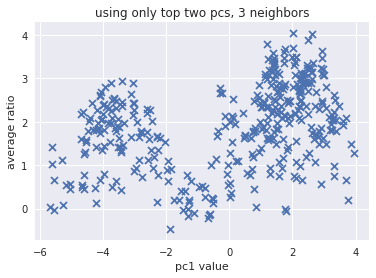

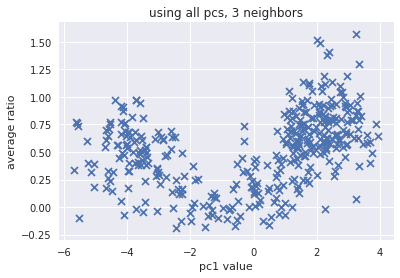

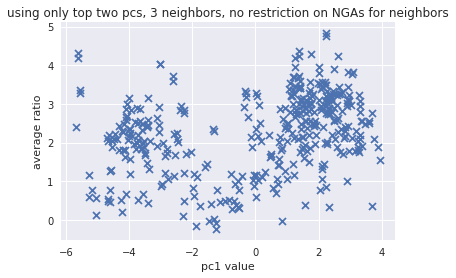

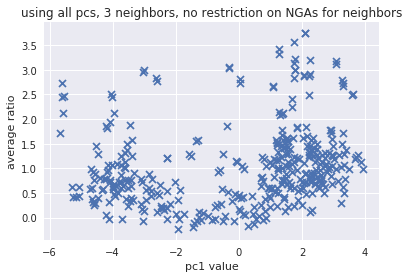

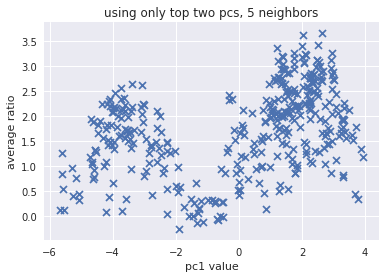

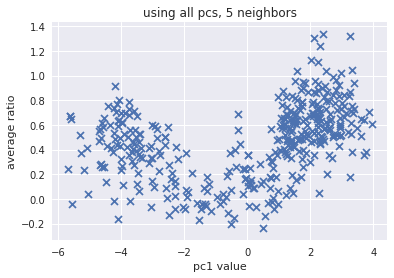

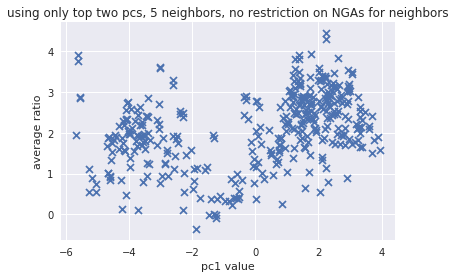

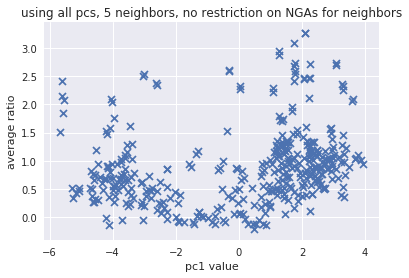

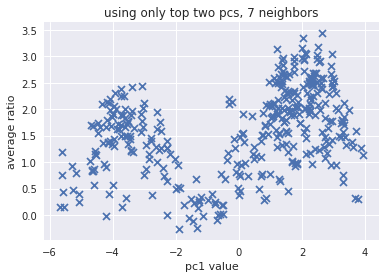

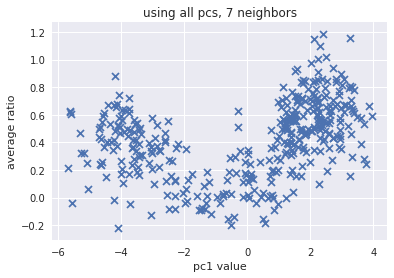

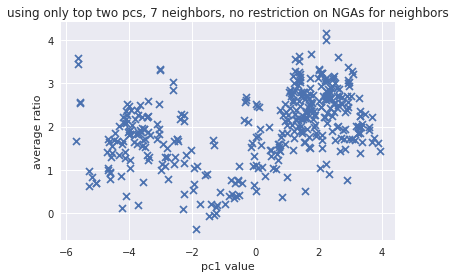

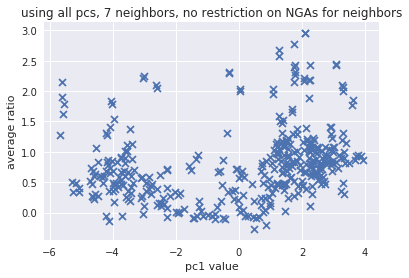

In [25]:
num_observ = movArrayOut.shape[0]
invalid_input = [i for i in range(num_observ) if np.isnan(movArrayOut[i, :, :]).any()]
flow_ngas = np.delete(flowInfo['NGA'].values, invalid_input)
movArrayOut2 = movArrayOut[list(set(range(num_observ)).difference(set(invalid_input))), :, :]
num_observ = movArrayOut2.shape[0]
assert len(flow_ngas) == num_observ

flow_distance(flow_ngas, movArrayOut2, 3, title = 'using only top two pcs, 3 neighbors')  # normalized, using only top two pcs
flow_distance(flow_ngas, movArrayOut2, 3, pc12=False, title = 'using all pcs, 3 neighbors') # normalized, using all dimensions
flow_distance(flow_ngas, movArrayOut2, 3, nbrnear=False, title = 'using only top two pcs, 3 neighbors, no restriction on NGAs for neighbors')  # normalized, using only top two pcs
flow_distance(flow_ngas, movArrayOut2, 3, nbrnear=False, pc12=False, title = 'using all pcs, 3 neighbors, no restriction on NGAs for neighbors') # normalized, using all dimensions
flow_distance(flow_ngas, movArrayOut2, 5, title = 'using only top two pcs, 5 neighbors')  # normalized, using only top two pcs
flow_distance(flow_ngas, movArrayOut2, 5, pc12=False, title = 'using all pcs, 5 neighbors') # normalized, using all dimensions
flow_distance(flow_ngas, movArrayOut2, 5, nbrnear=False, title = 'using only top two pcs, 5 neighbors, no restriction on NGAs for neighbors')  # normalized, using only top two pcs
flow_distance(flow_ngas, movArrayOut2, 5, nbrnear=False, pc12=False, title = 'using all pcs, 5 neighbors, no restriction on NGAs for neighbors') # normalized, using all dimensions
flow_distance(flow_ngas, movArrayOut2, 7, title = 'using only top two pcs, 7 neighbors')  # normalized, using only top two pcs
flow_distance(flow_ngas, movArrayOut2, 7, pc12=False, title = 'using all pcs, 7 neighbors') # normalized, using all dimensions
flow_distance(flow_ngas, movArrayOut2, 7, nbrnear=False, title = 'using only top two pcs, 7 neighbors, no restriction on NGAs for neighbors')  # normalized, using only top two pcs
flow_distance(flow_ngas, movArrayOut2, 7, nbrnear=False, pc12=False, title = 'using all pcs, 7 neighbors, no restriction on NGAs for neighbors') # normalized, using all dimensions
